In [1]:
import networkx as nx
import cv2
import numpy as np
import scipy as sp
import datetime as dt
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, fsolve
from scipy.spatial.transform import Rotation
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree

from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

import craterdetection.common.constants as const
from craterdetection.common.camera import Camera
from craterdetection.common.coordinates import nadir_attitude, ENU_system
from craterdetection.common.spice import get_sun_pos
from craterdetection.matching.database import extract_robbins_dataset, load_craters, CraterDatabase
from craterdetection.matching.position_estimation import derive_position
from craterdetection.matching.projective_invariants import crater_representation, CoplanarInvariants, scale_det
from craterdetection.matching.utils import cyclic_permutations, enhanced_pattern_shifting, is_clockwise, all_clockwise, \
    np_swap_columns, is_colinear, cw_or_ccw, get_cliques_by_length
from craterdetection.common.conics import *

In [2]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 10], ellipse_limit=1.1)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [3]:
resolution = (256, 256)

# Camera parameters can be derived from RNG
cam_lat, cam_long = map(np.radians, (45., 45.))
cam_alt = 150

cam = Camera.from_coordinates(cam_lat, cam_long, cam_alt, resolution=resolution)

# cam.T = (Rotation.from_matrix(cam.T) * Rotation.from_euler('x', 0, degrees=True)).as_matrix()

dist = cam_alt / np.cos(np.radians(cam.fov/2)*np.sqrt(2)*1.0)
vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
r_craters = r_craters_cat[vicinity]
C_craters = C_craters_cat[vicinity]
A_craters = cam.project_crater_conics(C_craters, r_craters)

crater_centers = cam.project_crater_centers(r_craters)

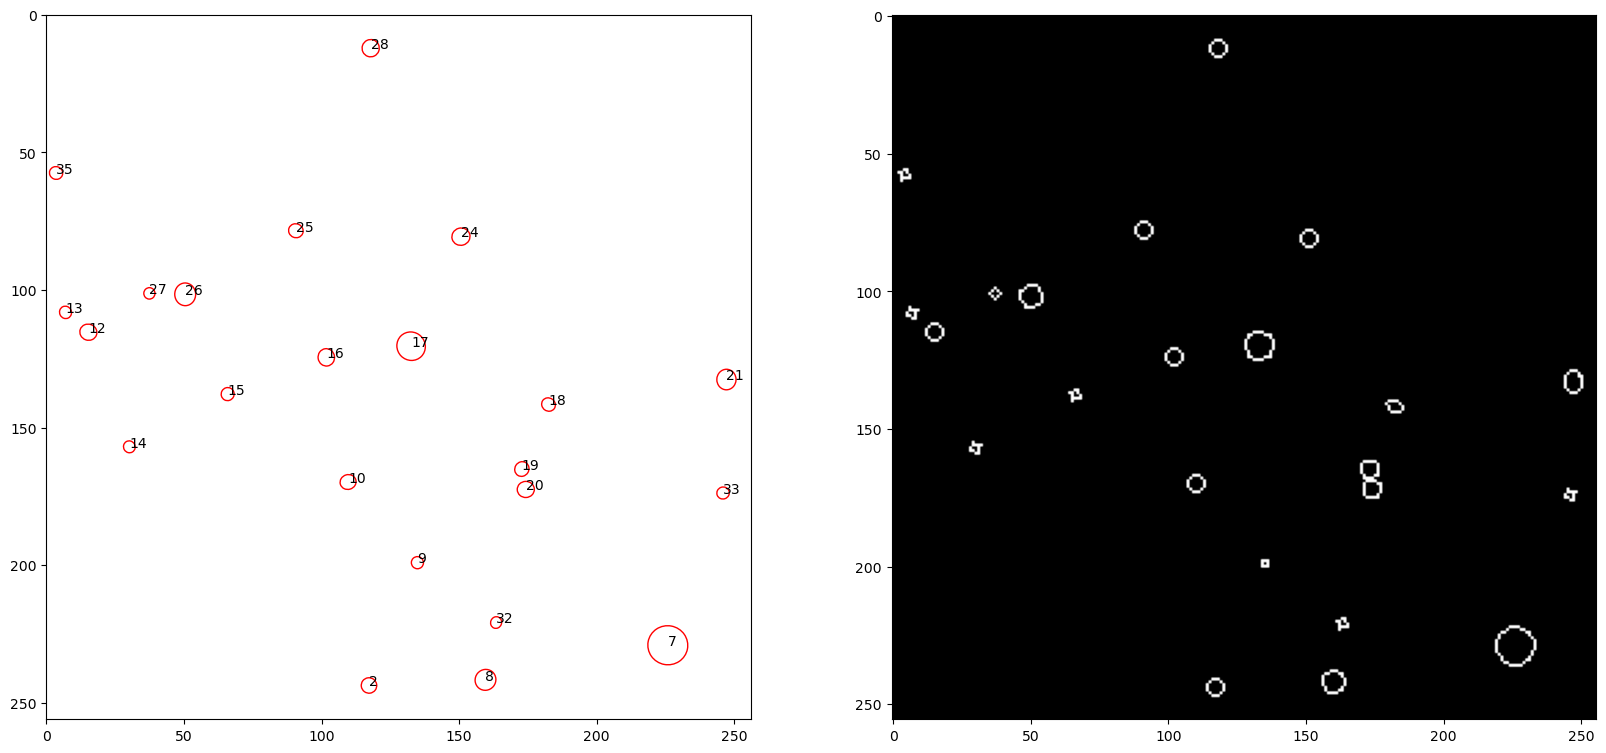

In [4]:
plt.style.use('default')

fig, axes = plt.subplots(1, 2, figsize=(20, 40), subplot_kw={'aspect': 'equal'})

plot_conics(A_craters, resolution=cam.resolution, plot_centers=True, ax=axes[0])
detection_order = np.argsort(cdist(crater_centers, np.array(cam.resolution)[None, :]/2).squeeze())

# plot_conics(A_craters[detection_order], resolution=cam.resolution, plot_centers=True, ax=axes[1])

img_ellipses = generate_mask(A_craters, resolution=resolution, instancing=False)

axes[1].imshow(img_ellipses, cmap='Greys_r')
fig.savefig('output/crater_mask_example.pdf', bbox_inches = 'tight', pad_inches = 0)

In [5]:
db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 10], latlims=[30, 60], longlims=[30, 60], radius=100)
# db = CraterDatabase(lat_cat[vicinity], long_cat[vicinity], major_cat[vicinity], minor_cat[vicinity], psi_cat[vicinity], radius=500)

In [6]:
np.set_printoptions(precision=3)
max_diff = 0.02
correct_matches = {detection_key : [] for detection_key, _ in enumerate(A_craters[detection_order])}
max_iter = 4

for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters[detection_order])):
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)

        diff = np.mean(np.abs(((db.features - features[order_full])/features[order_full])), axis=1)

        if np.min(diff) < max_diff:
            min_idx = np.argwhere(diff <= max_diff)

            subset_match = np.logical_and.reduce(lat_cat[vicinity][detection_order][crater_triad[order]] \
                                                                             == db.get_position(min_idx)[0].T, axis=2)
            if np.logical_or.reduce(subset_match):
                print(f"MATCH [{i}]")
                match = min_idx[np.where(subset_match)].item()
                print(crater_triad)
                print(order_full)

                rank = np.where(np.sort(diff) == diff[match])[0].item()
                print(f"\tMean difference: {diff[match]:.2%}, position: "
                      f"{rank}")

                print("\tDetection feature: \t", features[order_full])
                print("\tDB match feature: \t", db.features[match])

                print("\tCrater triad coords: \t",
                      lat_cat[vicinity][detection_order][crater_triad[order]],
                      long_cat[vicinity][detection_order][crater_triad[order]])
                print("\tDB match coords: \t", *db.get_position(match))
                for detection_idx, db_idx in zip(crater_triad[order], db.crater_triads[match]):
                    correct_matches[detection_idx] += [db_idx]
                print()
                break

    if i >= max_iter:
        break

MATCH [0]
[0 1 2]
[ 1  2  0  4  5  3 -1]
	Mean difference: 0.05%, position: 0
	Detection feature: 	 [ -61.798  -60.887  -10.173  -57.032  -38.827  -14.835 -244.834]
	DB match feature: 	 [ -61.76   -60.867  -10.17   -57.015  -38.79   -14.835 -244.609]
	Crater triad coords: 	 [0.786 0.774 0.788] [0.775 0.778 0.787]
	DB match coords: 	 [0.786 0.774 0.788] [0.775 0.778 0.787]

MATCH [1]
[4 3 5]
[ 2  0  1  5  3  4 -1]
	Mean difference: 0.10%, position: 0
	Detection feature: 	 [ -23.027 -168.094 -208.7    -20.757 -127.599 -250.068 -878.989]
	DB match feature: 	 [ -23.022 -167.954 -208.25   -20.755 -127.45  -249.699 -877.807]
	Crater triad coords: 	 [0.775 0.781 0.799] [0.803 0.807 0.794]
	DB match coords: 	 [0.775 0.781 0.799] [0.803 0.807 0.794]

MATCH [2]
[6 7 8]
[ 1  2  0  4  5  3 -1]
	Mean difference: 0.27%, position: 0
	Detection feature: 	 [ -467.149  -461.273  -157.624  -423.381  -536.416  -181.777 -2338.636]
	DB match feature: 	 [ -465.902  -459.539  -157.462  -422.015  -534.596  -18

In [7]:
n_det = len(A_craters)
# Add noise
major_det, minor_det = ellipse_axes(A_craters)
psi_det = ellipse_angle(A_craters)
r_craters_det = conic_center(A_craters)

major_det += np.random.rand(n_det) - 0.5
minor_det += np.random.rand(n_det) - 0.5
psi_det += np.random.rand(n_det) - 0.5
r_craters_det += np.random.randn(*r_craters_det.shape) - 0.5

A_craters_noisy = crater_representation(major_det, minor_det, psi_det, *r_craters_det.T)

In [17]:
%%time
np.set_printoptions(precision=3)
max_diff = 0.08
top_n = 10
matches = {detection_key : [] for detection_key, _ in enumerate(A_craters_noisy)}
max_iter = 50

db_tree = KDTree(db.features)

for crater_triad, features in CoplanarInvariants.match_generator(A_craters=A_craters_noisy, max_iter=max_iter):
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)
        d, min_n = db_tree.query(features[order_full], k=top_n, p=np.inf, workers=-1)
        diff = np.mean(np.abs(((db.features[min_n] - features[order_full])/features[order_full])), axis=1)
        # print(diff)
        if np.min(diff) < max_diff:
            for min_idx in min_n:
                for detection_idx, db_idx in zip(crater_triad[order], db.crater_triads[min_idx]):
                    matches[detection_idx] += [db_idx]

Wall time: 105 ms


In [71]:
%%time
batch_size = 5000
top_n = 10
min_n = np.empty((batch_size, 3, top_n), int)
d_n = np.empty((batch_size, 3, top_n), np.float32)

match_threshold = 200

matches = np.empty((batch_size, 3, 3))

crater_triad, features = next(CoplanarInvariants.match_generator(A_craters=A_craters_noisy, max_iter=max_iter, batch_size=batch_size))
for i, order in enumerate(cyclic_permutations(np.arange(3))):
    order_full = np.append(np.concatenate((order, order+3)), -1)
    d_n[:, i], min_n[:, i] = db_tree.query(features[:, order_full], k=top_n, p=1, workers=-1)
d_n.reshape((-1, 20))
id, idx, counts = np.unique(min_n, return_counts=True, return_index=True)
match_mask = counts > match_threshold
db.crater_triads[min_n].shape

Wall time: 130 ms


(5000, 3, 10, 3)

In [ ]:
matches_val = dict()

for k, v in matches.items():
    if len(v) >= 2*top_n:
        match_idx, counts = np.unique(np.array(v), return_counts=True)
        ord = np.argsort(counts)
        if counts[ord][-1] > 5:
            print(k, match_idx[ord][-1].item())
            matches_val[k] = match_idx[ord][-1].item()

list(matches_val.values())
A_craters_det = A_craters_noisy[list(matches_val.keys())]
r_craters_det = db.r_craters[list(matches_val.values())]
C_craters_det = db.C_cat[list(matches_val.values())]

est_r = derive_position(A_craters_det, r_craters_det, C_craters_det, cam.T, cam.K())
print(f"Position error: {(LA.norm(cam.r.ravel() - est_r.ravel())):.2f} km")

In [ ]:
%%time
est_r = derive_position(*db.match_detections(A_craters_noisy, max_iter=200, threshold=0.05), cam.T, cam.K())
print(f"Position error: {(LA.norm(cam.r.ravel() - est_r.ravel())):.2f} km")

# MC Simulation

In [ ]:
latlims = (45, 60)
longlims = (45, 60)
diamlims = (2, 30)
ellipse_limit = 1.2
arclims = 0.5

triad_radius = 100

lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters(
        "../data/lunar_crater_database_robbins_2018.csv",
        latlims=latlims,
        longlims=longlims,
        diamlims=diamlims,
        ellipse_limit=ellipse_limit,
        arc_lims=arclims
    )
)
db = CraterDatabase(lat_cat, long_cat, major_cat, minor_cat, psi_cat, radius=triad_radius)

r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [ ]:
test_size = 10
resolution = (256, 256)

position_dataset = np.empty((test_size, 3, 1), np.float64)
attitude_dataset = np.empty((test_size, 3, 3), np.float64)

est_position_dataset = np.empty((test_size, 3, 1), np.float64)

position_noise = 2 #pixels
axis_noise = 1 #pixels
angle_noise = np.radians(20)

max_iter = 200
match_threshold = 0.01

for i in range(test_size):

    lat = np.random.uniform(*latlims)
    long = np.random.uniform(*longlims)
    cam_alt = np.random.uniform(150, 250)
    cam = Camera.from_coordinates(lat,
                                  long,
                                  cam_alt,
                                  convert_to_radians=True,
                                  resolution=resolution
                                  )

    # save cam.r, sol_incidence
    position_dataset[i] = cam.r

    # Rotations are incremental (order matters)
    cam.rotate('roll', np.random.uniform(0, 360))
    cam.rotate('pitch', np.random.uniform(-30, 30))
    cam.rotate('yaw', np.random.uniform(-30, 30))

    # save cam.T
    attitude_dataset[i] = cam.T

    visible = (cdist(r_craters_cat.squeeze(), cam.r.T) <= np.sqrt(2 * cam_alt * const.RMOON + cam_alt**2)).ravel()
    r_craters = r_craters_cat[visible]
    C_craters = C_craters_cat[visible]

    r_craters_img = cam.project_crater_centers(r_craters)
    in_image = np.logical_and.reduce(np.logical_and(r_craters_img > -20, r_craters_img < cam.resolution[0]+20), axis=1)

    r_craters = r_craters[in_image]
    C_craters = C_craters[in_image]

    A_craters = cam.project_crater_conics(C_craters, r_craters)
    n_det = len(A_craters)

    major_det, minor_det = ellipse_axes(A_craters)
    psi_det = ellipse_angle(A_craters)
    r_craters_det = conic_center(A_craters)

    major_det += np.random.uniform(-axis_noise, axis_noise, n_det)
    minor_det += np.random.uniform(-axis_noise, axis_noise, n_det)
    psi_det += np.random.uniform(-angle_noise, angle_noise, n_det)
    r_craters_det += np.random.uniform(-position_noise, position_noise, r_craters_det.shape)

    A_craters_noisy = crater_representation(major_det, minor_det, psi_det, *r_craters_det.T)
    if n_det >= 3:
        A_craters_det, r_craters_det, C_craters_det = db.match_detections(
                                                                  A_craters_noisy,
                                                                  max_iter=max_iter,
                                                                  threshold=match_threshold
                                                              )
        if len(A_craters_det) > 1:
            est_position_dataset[i] = derive_position(
                A_craters_det,
                r_craters_det,
                C_craters_det,
                cam.T,
                cam.K()
            )
        else:
            est_position_dataset[i] = np.ones((3,1))*-1
    else:
        est_position_dataset[i, ...] = -1

In [ ]:
matched_positions = (est_position_dataset[:,0,:] != -1).ravel()
est_position_dataset[matched_positions] - position_dataset[matched_positions]